#### this script will detect missing days of data

In [1]:
import glob
import pandas as pd
import calendar
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
def do_all_days_exist(df, year, month):
    daysinmonth = calendar.monthrange(int(year), int(month))[1]  # get all days in month
    downloaded_days = len(df["init_date"].unique())
    if daysinmonth != downloaded_days:
        print(
            f"🚨🚨🚨 there are {daysinmonth-downloaded_days} days of data missing! 🚨🚨🚨"
        )


def find_available_data_percentage(df, year, month, model, df_per):
    init00 = "0000"
    init12 = "1200"
    if model == "HRRR":
        fh = range(0, 19)  # (0, 19)forecast hours, second num exclusive
        init00 = "t00z"
        init12 = "t12z"
    elif model == "NAM":
        fh = np.arange(0, 37, 1).tolist() + np.arange(39, 85, 3).tolist()
    elif model == "GFS":
        fh = np.arange(0, 99, 3)

    daysinmonth = calendar.monthrange(int(year), int(month))[1]  # get all days in month
    allpossiblefiles = daysinmonth * len(fh)
    print("allpossiblefiles", allpossiblefiles)
    utc_00 = (
        df.groupby(["init_hour", "init_date"]).count().loc[init00]["file_path"].sum()
    )
    utc_12 = (
        df.groupby(["init_hour", "init_date"]).count().loc[init12]["file_path"].sum()
    )
    print("utc_00", utc_00)

    per00 = 100.0 * (utc_00 / allpossiblefiles)
    per12 = 100.0 * (utc_12 / allpossiblefiles)
    print(f"{per00:0.1f}% of 00 UTC data is available")
    print(f"{per12:0.1f}% of 12 UTC data is available")
    df_per.loc[month]["00 UTC"] = per00.round(1)
    df_per.loc[month]["12 UTC"] = per12.round(1)
    return df_per

In [3]:
def main(model, year):
    if model != "HRRR":
        file_exten = ".grb2"
    else:
        file_exten = ".grib2"
    fp = f"/home/lgaudet/model-data/{model}/{year}/"

    df_per = pd.DataFrame(columns=["00 UTC", "12 UTC"], index=np.arange(1, 13))

    for month in range(1, 13):
        print("--------------")
        print(calendar.month_name[month])
        print("--------------")
        files = glob.glob(f"{fp}{str(month).zfill(2)}/*{file_exten}")
        files.sort()

        df = pd.DataFrame(files, columns=["file_path"])
        df["file_name"] = df["file_path"].apply(lambda x: x.split("/")[-1])
        if model != "HRRR":
            df["init_date"] = df["file_name"].apply(lambda x: x.split("_")[2])
            df["init_hour"] = df["file_name"].apply(lambda x: x.split("_")[3])
        else:
            df["init_date"] = df["file_name"].apply(lambda x: x.split("_")[0])
            df["init_hour"] = (
                df["file_name"]
                .apply(lambda x: x.split("_")[1])
                .apply(lambda x: x.split(".")[1])
            )

        groupby_count = df.groupby(["init_date"]).count()

        do_all_days_exist(df, year, month)

        if groupby_count.min()[0] != groupby_count.max()[0]:
            print("max: ", groupby_count.max()[0])
            print(
                groupby_count.loc[groupby_count["init_hour"] < groupby_count.max()[0]]
            )
            print(
                "potentially missing files: ",
                groupby_count.loc[
                    groupby_count["init_hour"] == groupby_count.min()[0]
                ].index,
            )
        else:
            print("no missing files")

        df_per = find_available_data_percentage(df, year, month, model, df_per)
    return df, df_per

In [4]:
def plot_data_heatmap(df_per, model, year):
    plt.figure(figsize=(3, 5))
    sns.heatmap(
        df_per.astype(float),
        linewidths=0.1,
        annot=True,
        fmt="2g",
        vmin=90,
        vmax=100,
        cmap=cm.cividis_r,
    )
    plt.ylabel("Month")
    plt.xlabel("Initialization Time")
    plt.title(f"{model}: {year}")
    plt.tight_layout()
    # plt.savefig(f'../Figures/files_exist_{model}_{year}.png', dpi=200, facecolor='white', transparent=False)

--------------
January
--------------
no missing files
allpossiblefiles 1023
utc_00 1023
100.0% of 00 UTC data is available
100.0% of 12 UTC data is available
--------------
February
--------------
no missing files
allpossiblefiles 924
utc_00 924
100.0% of 00 UTC data is available
100.0% of 12 UTC data is available
--------------
March
--------------
max:  66
           file_path  file_name  init_hour
init_date                                 
20210320          65         65         65
potentially missing files:  Index(['20210320'], dtype='object', name='init_date')
allpossiblefiles 1023
utc_00 1023
100.0% of 00 UTC data is available
99.9% of 12 UTC data is available
--------------
April
--------------
no missing files
allpossiblefiles 990
utc_00 990
100.0% of 00 UTC data is available
100.0% of 12 UTC data is available
--------------
May
--------------
no missing files
allpossiblefiles 1023
utc_00 1023
100.0% of 00 UTC data is available
100.0% of 12 UTC data is available
--------------

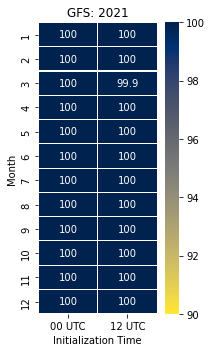

In [5]:
years = [2018, 2019, 2020, 2021]
models = ["GFS", "NAM", "HRRR"]
if models[0] == "HRRR":
    fh = range(0, 19)
elif models[0] == "NAM":
    fh = np.arange(0, 37, 1).tolist() + np.arange(39, 85, 3).tolist()
elif models[0] == "GFS":
    fh = np.arange(0, 99, 3)

for year in years:
    for model in models:
        df, df_per = main(model, year)
        plot_data_heatmap(df_per, model, year)

In [6]:
df.groupby(["init_hour", "init_date"]).count().loc["0000"]["file_path"]

init_date
20211201    33
20211202    33
20211203    33
20211204    33
20211205    33
20211206    33
20211207    33
20211208    33
20211209    33
20211210    33
20211211    33
20211212    33
20211213    33
20211214    33
20211215    33
20211216    33
20211217    33
20211218    33
20211219    33
20211220    33
20211221    33
20211222    33
20211223    33
20211224    33
20211225    33
20211226    33
20211227    33
20211228    33
20211229    33
20211230    33
20211231    33
Name: file_path, dtype: int64